# 设定路径

In [2]:
def setProjectPath(projectPath):
    import os
    import sys
    root=os.path.abspath(projectPath)
    print(root)
    sys.path.append(root)
    os.environ["TORCH_HOME"]=r"E:\Data\torch-model"
    import warnings  
    warnings.filterwarnings("ignore", category=RuntimeWarning, module="mne")

projectPath=r'D:\project_meta\NNproject\NNI'
setProjectPath(projectPath)

D:\project_meta\NNproject\NNI


# 实验一
- 

## 数据集

In [3]:
import torch
from project.dataset.SelfDataset import TableControlFullLoadDataset
from project.dataprocess import FolderTree
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset, SubsetRandomSampler
from torch.utils.data import Dataset
import pandas as pd
from typing import Any
class TableDataset(Dataset):
    def __init__(self,table:pd.DataFrame) -> None:
        super().__init__()
        self.Table=table
    def __len__(self):
        return len(self.Table)
    def __getitem__(self, index) -> Any:
        return self.Table.iloc[index].to_dict()
#路径
data_root=r'D:\dataset\driver_dataset\DROZY\DROZY'
output_root=r"D:\project_meta\NNproject\NNI\output"

data_path_dict=FolderTree.getDataPath(data_root=data_root)
output_path_dic=FolderTree.getOutPath(output_root=output_root)

#表
bandPowerTable=pd.read_csv(r"D:\project_meta\NNproject\NNI\output\bandpoweruniform.csv")
#数据集分割
trainDataTable,testDataTable=train_test_split(bandPowerTable,test_size=0.35,shuffle=True)

#数据加载器
train_dataset=TableDataset(trainDataTable)
train_dataloader=DataLoader(train_dataset,batch_size=512,shuffle=True)

test_dataset=TableDataset(testDataTable)
test_dataloader=DataLoader(test_dataset,batch_size=512)

## MLP模型

In [4]:
import torch.nn as nn
def MLP(numFeature,interWidth,classes):
    interWidth.insert(0,numFeature)
    interWidth.append(classes)
    net=nn.Sequential()
    for i in range(len(interWidth)-2) :
        net.append(nn.Linear(interWidth[i],interWidth[i+1]))
        #net.append(nn.Dropout(0.5))
        net.append(nn.ReLU())
    net.append(nn.Linear(interWidth[-2],interWidth[-1]))
    return net
    pass


## 模型验证

In [5]:
from torchsummary import summary
InterWidth=[32,64,16]
batch=next(iter(train_dataloader))
NumFeature=pd.DataFrame(batch).drop(columns=['ID','LEVEL','KSS']).shape[-1]
classes=NumFeature
print(f'数据维度：{NumFeature}\n类别数：{classes}')

print("InterWidth",InterWidth)

net=MLP(numFeature=NumFeature,interWidth=InterWidth,classes=classes)
print(net)
summary(net,(1,NumFeature),batch_size=5,device='cpu')

数据维度：25
类别数：25
InterWidth [32, 64, 16]
Sequential(
  (0): Linear(in_features=25, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=25, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [5, 1, 32]             832
              ReLU-2                 [5, 1, 32]               0
            Linear-3                 [5, 1, 64]           2,112
              ReLU-4                 [5, 1, 64]               0
            Linear-5                 [5, 1, 16]           1,040
              ReLU-6                 [5, 1, 16]               0
            Linear-7                 [5, 1, 25]             425
Total params: 4,409
Trainable params: 4,409
Non-trainable params: 0
----------------------------

## 训练模型

In [6]:
from d2l import torch as d2l
import torch.nn as nn 
import torch.nn.functional as F
import torch
import datetime
import os

### 参数权重存储路径

In [7]:

device=torch.device('cuda')
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")
parameterFolder=os.path.join(r"D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D",f"{formatted_time}")
print(parameterFolder)

D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D\2023_11_13_12_20_47


### 超参数

In [8]:
LR=0.5
Optimizer=torch.optim.SGD
LossFuntion=nn.CrossEntropyLoss
LRScheduler=torch.optim.lr_scheduler.StepLR
StepLRGamma=0.7
StepLRStep=80
LayerSet=[256, 512, 64, 3]
NumFeature=pd.DataFrame(batch).drop(columns=['ID','LEVEL','KSS']).shape[-1]
LevelClasses=3
KSSClasses=10
EochsNum=500

In [9]:
net=MLP(NumFeature,LayerSet,LevelClasses)
optim=Optimizer(net.parameters(),lr=LR,)
lrScheduler=LRScheduler(optim,StepLRStep,StepLRGamma)
lossFuntion=LossFuntion()

In [10]:
current_time = datetime.datetime.now()
formatted_time = current_time.strftime("%Y_%m_%d_%H_%M_%S")
parameterFolder=os.path.join(r"D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D",f"{formatted_time}")
print(parameterFolder)
os.makedirs(parameterFolder)

best_train_acc=0
best_train_loss=0
best_test_acc=0
stagnate_times=0
temp_acc=0
num_batches = len(train_dataloader)
device=torch.device('cuda')
net.to(device)
  

D:\project_meta\NNproject\NNI\output\model_parameter\FilterSignalCNN1D\2023_11_13_12_20_47


Sequential(
  (0): Linear(in_features=25, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=3, bias=True)
  (7): ReLU()
  (8): Linear(in_features=3, out_features=3, bias=True)
)

torch.Size([512, 1, 25])
y.shape torch.Size([512])
y_hat.shape torch.Size([512, 3])
torch.Size([512, 1, 25])
y.shape torch.Size([512])
y_hat.shape torch.Size([512, 3])
torch.Size([512, 1, 25])
y.shape torch.Size([512])
y_hat.shape torch.Size([512, 3])


KeyboardInterrupt: 

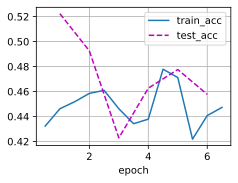

In [15]:

animator = d2l.Animator(xlabel='epoch',
                        legend=['train_acc','test_acc'])
for epoch in range(EochsNum):
    metric_train = d2l.Accumulator(2)
    net.train()
    for i,data in enumerate(train_dataloader):
        #print(data)

        optim.zero_grad()

        pddata=pd.DataFrame(data)
        x=pddata.drop(columns=['ID','KSS','LEVEL']).values
        x=torch.tensor(x).unsqueeze(1).to(torch.float32).to(device)
        print(x.shape)
        y_hat=net(x)
        y_hat=torch.squeeze(y_hat, dim=1)
        y=torch.tensor(pddata['LEVEL'].values)-1
        y=y.long().to(device)       
        l=lossFuntion(y_hat, y)
        print("y.shape",y.shape)
        print("y_hat.shape",y_hat.shape)
        l.backward()
        optim.step()
        pre=torch.argmax(y_hat.detach().cpu(),dim=1)
        num_true=sum(pre==y.cpu())
        metric_train.add(num_true,y.numel())
        if (i + 1) % (num_batches // 2) == 0 or i == num_batches - 1:
            animator.add(epoch + (i + 1) / num_batches, (metric_train[0]/metric_train[1],None))
        if best_train_acc<(metric_train[0]/metric_train[1]):
            best_train_acc=metric_train[0]/metric_train[1]
            stagnate_times=0
            torch.save(net.state_dict(),os.path.join(parameterFolder,f'{best_train_acc}.pt'))

        
    net.eval()
    metric_test = d2l.Accumulator(2)
    with torch.no_grad():
        testnum_batches = len(test_dataloader)
        for data_dict in test_dataloader:

            pddata=pd.DataFrame(data)
            x=pddata.drop(columns=['ID','KSS','LEVEL']).values
            x=torch.tensor(x).unsqueeze(1).to(torch.float32).to(device)
            # print(x.shape)
            y_hat=net(x)
            y_hat=torch.squeeze(y_hat, dim=1)
            y=torch.tensor(pddata['LEVEL'].values)-1
            y=y.long().to(device)
        
            pre=torch.argmax(y_hat.detach().cpu(),dim=1)
            num_true=sum(pre==y.cpu())
            metric_test.add(num_true,y.numel())
            animator.add(epoch+ (i + 1) / num_batches, (None,metric_test[0]/metric_test[1]))

